In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from typing import Any, List, Dict, Tuple
from collections import defaultdict, Counter
from google.colab import drive
drive.mount("/content/drive")
ROOT_DIR = "/content/drive/My Drive/"
PROJ_DIR = ROOT_DIR + "Term_Project_Unsupervised_Learners/"
DATA_DIR = PROJ_DIR + "data/"
FEAT_DIR = PROJ_DIR + "feature_test2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls "/content/drive/My Drive/Term_Project_Unsupervised_Learners/data/"
path = "/content/drive/My Drive/Term_Project_Unsupervised_Learners/data/"

aggregated_all_useful_columns_for_feature_engineering.csv
aggregated_final_clean_actor_director_istopk_logrev.csv
aggregated_final_clean_actor_director_istopk_logrev.gsheet
aggregated_final_clean_actor_istopk_logrev.csv
aggregated_selected_columns.csv
aggregated_selected_columns_full_revenue.csv
aggregated_selected_columns_with_actor_director_istopk_logrev.csv
aggregated_seriously_no_missing.csv
correlation_matrix1.csv
correlation_matrix.csv
original_data
preprocessing
test_2015_2017.csv
test_2015_2017_final.csv
test_2015_2017_prod_comp_class_actor_director_istopk_logrev.csv
test_2015_2017_prod_comp_class_actor_director_istopk_logrev_cubic_extrapolation.csv
test_2015_2017_prod_comp_class_actor_director_istopk_logrev_genres.csv
test_2015_2017_prod_comp_class_actor_director_istopk_logrev_linear_extrapolation.csv
test_2015_2017_prod_comp_class_actor_director_istopk_logrev_logpop.csv
test_2015_2017_prod_comp_class_actor_director_istopk_logrev_median.csv
test_2015_2017_prod_comp_class.csv
t

In [8]:
def saveFeature(feat: Any, feat_name: str):
    feat_path = FEAT_DIR + feat_name + ".pt"
    if not os.path.exists(FEAT_DIR):
        os.makedirs(FEAT_DIR)
    pickle.dump(feat, open(feat_path, "wb"))

def loadFeature(feat_name: str) -> Any:
    feat_path = FEAT_DIR + feat_name + ".pt"
    return pickle.load(open(feat_path, "rb")) if os.path.exists(feat_path) else None

In [9]:
def generate_year_pairs(start_year: int, end_year: int, duration: int) -> List[Tuple[int, int]]:
    return [(year - duration, year) for year in range(start_year, end_year + 1)]

def generate_feat_data_name_tmpl(feat_name):
    if feat_name == "is_topk_roles":
        return "{d}_top{k}_{r}_freq_pairs_in_{sy}_{ey}"
    elif feat_name == "role_logrev":
        return "{d}_{r}_role_logrev_in_{sy}_{ey}"
    elif feat_name == "role_logpop":
        return "{d}_{r}_role_logpop_in_{sy}_{ey}"
    return None

def generate_year_pair_to_topk_roles(role_name: str, role_k: int,
                                     duration: int, data_name: str,
                                     start_year: int, end_year: int) -> Dict[Tuple[str, str], List[str]]:
    feat_name_tmpl = generate_feat_data_name_tmpl("is_topk_roles")
    year_pair_to_topk_roles = {}
    for year_pair in generate_year_pairs(start_year, end_year, duration):
        topk_role_freqs = loadFeature(feat_name_tmpl.format(d=data_name, k=role_k, r=role_name,
                                                            sy=year_pair[0], ey=year_pair[1]))
        if topk_role_freqs:
            year_pair_to_topk_roles[year_pair] = [role for role, _ in topk_role_freqs]
    return year_pair_to_topk_roles

def generate_year_pair_to_role_logpop(role_name: str, duration: int, data_name: str,
                                      start_year: int, end_year: int) -> Dict[Tuple[str, str], List[str]]:
    feat_name_tmpl = generate_feat_data_name_tmpl("role_logpop")
    year_pair_to_role_logpop = {}
    for year_pair in generate_year_pairs(start_year, end_year, duration):
        role_logpop = loadFeature(feat_name_tmpl.format(d=data_name, r=role_name,
                                                        sy=year_pair[0], ey=year_pair[1]))
        if "<unk>" not in role_logpop:
            role_logpop["<unk>"] = np.median(list(role_logpop.values()))
        year_pair_to_role_logpop[year_pair] = role_logpop
    return year_pair_to_role_logpop

def generate_year_pair_to_role_logrev(role_name: str, duration: int, data_name: str,
                                      start_year: int, end_year: int) -> Dict[Tuple[str, str], List[str]]:
    feat_name_tmpl = generate_feat_data_name_tmpl("role_logrev")
    year_pair_to_role_logrev = {}
    for year_pair in generate_year_pairs(start_year, end_year, duration):
        role_logrev = loadFeature(feat_name_tmpl.format(d=data_name, r=role_name,
                                                        sy=year_pair[0], ey=year_pair[1]))
        if "<unk>" not in role_logrev:
            role_logrev["<unk>"] = np.median(list(role_logrev.values()))
        year_pair_to_role_logrev[year_pair] = role_logrev
    return year_pair_to_role_logrev

In [10]:
def computeTopKRoleFreqs(role_k: int, df: pd.DataFrame, role_col_name: str,
                         year_col_name: str, year_pair: Tuple[str, str] = None) -> List[Tuple[str, int]]:
    """
    Parameter:
        role_k: number of roles (actor/director)
        df: data frame
        role_col_name: column name of roles of each movie
        year_col_name: column name of the release year of each movie
        year_pair (start_year, end_year): selected range of years, default: None, all range is selected
    Return:
        List of top k (role_name, frequency)
    """
    if isinstance(year_pair, tuple) and len(year_pair) == 2:
        new_df = df.loc[:, [role_col_name, year_col_name]]
        year_col = new_df[year_col_name]
        new_df = new_df[(year_col >= year_pair[0]) & (year_col < year_pair[1])]
    else:
        new_df = df.loc[:, [role_col_name, year_col_name]]

    roles_list = new_df[role_col_name].to_numpy()
    topk_role_freqs = Counter([role for roles in roles_list for role in roles]).most_common(role_k)
    return [(role, freq) for role, freq in topk_role_freqs]

In [11]:
def computeRoleLogRevenue(role_col_name: str,
                          df: pd.DataFrame, rev_col_name: str, year_col_name: str,
                          max_num_roles: int, year_pair: Tuple[str, str] = None) -> List[Tuple[str, int]]:
    """
    Parameter:
        role_col_name: column name of top roles of each movie
        df: data frame
        rev_col_name: column_name of log(revenue)
        year_col_name: column name of the release year of each movie
        max_num_roles: maximal number of roles of each movie
        year_pair (start_year, end_year): selected range of years, default: None, all range is selected
    Return:
        Dict of role's log(revenue) within year range: {role_name: log(revenue)}
    """
    if isinstance(year_pair, tuple) and len(year_pair) == 2:
        new_df = df.loc[:, [role_col_name, year_col_name, rev_col_name]]
        year_col = new_df[year_col_name]
        new_df = new_df[(year_col >= year_pair[0]) & (year_col < year_pair[1])]
    else:
        new_df = df.loc[:, [role_col_name, year_col_name, rev_col_name]]

    role_to_logrev = {}
    for _, row in new_df.iterrows():
        roles = row[role_col_name]
        for i in range(max_num_roles):
            role = roles[i] if i < len(roles) else "<unk>"
            if role not in role_to_logrev:
                role_to_logrev[role] = []
            role_to_logrev[role].append(np.log(row[rev_col_name]))
    for role in role_to_logrev:
        role_to_logrev[role] = np.mean(role_to_logrev[role])
    return role_to_logrev

In [12]:
def addIsTopKRolesFeatCol(role_name: str, role_k: int, duration: int,
                          year_pair_to_topk_roles: Dict[Tuple[str, str], List[str]],
                          df: pd.DataFrame, role_col_name: str, year_col_name: str,
                          max_num_roles: int, is_train: bool) -> pd.DataFrame:
    new_df = df.copy()
    is_topk_role_col_name_tmpl = "{r}_is_top_{k}_of_past_{d}_years_{i}"
    tmp_topk_role_col_name = "_is_topk_roles"
    def _getIsTopKRoles(row, i):
        if i < len(row[role_col_name]):
            return int(row[role_col_name][i] in row[tmp_topk_role_col_name])
        return 0
    if is_train:
        new_df[tmp_topk_role_col_name] = df[year_col_name].apply(lambda yr: set(year_pair_to_topk_roles.get((yr - duration, yr), [])))
    else:
        max_year_pair = max(year_pair_to_topk_roles.keys())
        new_df[tmp_topk_role_col_name] = df[year_col_name].apply(lambda yr: year_pair_to_topk_roles[max_year_pair])
    
    for i in range(max_num_roles):
        is_topk_role_col_name = is_topk_role_col_name_tmpl.format(r=role_name, k=role_k, d=duration, i=i)
        role_topk_role_df = new_df[[role_col_name, tmp_topk_role_col_name]]
        new_df[is_topk_role_col_name] = role_topk_role_df.apply(lambda row: _getIsTopKRoles(row, i), axis=1)

    new_df.drop(columns=[tmp_topk_role_col_name], inplace=True)
    return new_df

In [13]:
def addRoleLogPopFeatCol(role_name: str, duration: int,
                         year_pair_to_role_logpop: Dict[Tuple[str, str], Dict[str, int]],
                         df: pd.DataFrame, role_col_name: str, year_col_name: str,
                         max_num_roles: int, is_train: bool,
                         filling_method: str="max_year") -> pd.DataFrame:
    new_df = df.copy()    
    role_logpop_col_name_tmpl = "{r}_logpop_of_past_{d}_years_{i}"
    tmp_role_logpop_col_name = "_role_logpop"

    def _max_year_filling(year, role_to_year_pair_logpop):
        role_logpop = {}
        for role, year_pair_logpop in role_to_year_pair_logpop.items():
            role_logpop[role] = year_pair_logpop["logpop"][-1]
        return role_logpop

    def _getRoleLogPop(row, i):
        roles, role_logpop = row[role_col_name], row[tmp_role_logpop_col_name]
        if i < len(roles) and roles[i] in role_logpop:
            return role_logpop[roles[i]]
        return role_logpop.get('<unk>', -1)

    if is_train:
        new_df[tmp_role_logpop_col_name] = df[year_col_name].apply(lambda yr: year_pair_to_role_logpop.get((yr - duration, yr), {}))
    else:
        role_to_year_pair_logpop = {}
        for year_pair, role_logpop in year_pair_to_role_logpop.items():
            for role, logpop in role_logpop.items():
                if role not in role_to_year_pair_logpop:
                    role_to_year_pair_logpop[role] = {"year_pair": [], "logpop": []}
                role_to_year_pair_logpop[role]["year_pair"].append(year_pair)
                role_to_year_pair_logpop[role]["logpop"].append(logpop)
        if filling_method == "max_year":
            new_df[tmp_role_logpop_col_name] = df[year_col_name].apply(
                lambda yr: _max_year_filling(yr, role_to_year_pair_logpop)
            )
        
    for i in range(max_num_roles):
        role_logpop_col_name = role_logpop_col_name_tmpl.format(r=role_name, d=duration, i=i)
        role_logpop_df = new_df[[role_col_name, tmp_role_logpop_col_name]]
        new_df[role_logpop_col_name] = role_logpop_df.apply(lambda row: _getRoleLogPop(row, i), axis=1)
        med = new_df[role_logpop_col_name][new_df[role_logpop_col_name] >= 0].median()
        new_df[role_logpop_col_name].replace(-1, med, inplace=True)

    new_df.drop(columns=[tmp_role_logpop_col_name], inplace=True)
    return new_df

In [14]:
def addRoleLogRevFeatCol(role_name: str, duration: int,
                         year_pair_to_role_logrev: Dict[Tuple[str, str], Dict[str, int]],
                         df: pd.DataFrame, role_col_name: str, year_col_name: str,
                         max_num_roles: int, is_train: bool,
                         filling_method: str="max_year") -> pd.DataFrame:
    new_df = df.copy()    
    role_logrev_col_name_tmpl = "{r}_logrev_of_past_{d}_years_{i}"
    tmp_role_logrev_col_name = "_role_logrev"

    def _max_year_filling(year, role_to_year_pair_logrev):
        role_logrev = {}
        for role, year_pair_logrev in role_to_year_pair_logrev.items():
            role_logrev[role] = year_pair_logrev["logrev"][-1]
        return role_logrev

    def _linear_extrapolation_filling(year, role_to_fit):
        role_logrev = {}
        for role, fit in role_to_fit.items():
            role_logrev[role] = np.poly1d(fit)(year)
        return role_logrev

    def _cubic_extrapolation_filling(year, role_to_fit):
        role_logrev = {}
        for role, fit in role_to_fit.items():
            role_logrev[role] = np.poly3d(fit)(year)
        return role_logrev

    def _getRoleLogRev(row, i):
        roles, role_logrev = row[role_col_name], row[tmp_role_logrev_col_name]
        if i < len(roles) and roles[i] in role_logrev:
            return role_logrev[roles[i]]
        return role_logrev.get('<unk>', -1)

    if is_train:
        new_df[tmp_role_logrev_col_name] = df[year_col_name].apply(lambda yr: year_pair_to_role_logrev.get((yr - duration, yr), {}))
    else:
        role_to_year_pair_logrev = {}
        for year_pair, role_logrev in year_pair_to_role_logrev.items():
            for role, logrev in role_logrev.items():
                if role not in role_to_year_pair_logrev:
                    role_to_year_pair_logrev[role] = {"year_pair": [], "logrev": []}
                role_to_year_pair_logrev[role]["year_pair"].append(year_pair)
                role_to_year_pair_logrev[role]["logrev"].append(logrev)
        if filling_method == "max_year":
            new_df[tmp_role_logrev_col_name] = df[year_col_name].apply(
                lambda yr: _max_year_filling(yr, role_to_year_pair_logrev)
            )
        elif filling_method == "median":
            role_to_median_logrev = {}
            for role, year_pair_logrev in role_to_year_pair_logrev.items():
                years = [year_pair[1] for year_pair in year_pair_logrev["year_pair"]]
                logrevs = year_pair_logrev["logrev"]
                role_to_median_logrev[role] = np.median(logrevs)
            new_df[tmp_role_logrev_col_name] = df[year_col_name].apply(
                lambda yr: role_to_median_logrev
            )
        elif filling_method == "linear_extrapolation":
            role_to_fit = {}
            for role, year_pair_logrev in role_to_year_pair_logrev.items():
                years = [year_pair[1] for year_pair in year_pair_logrev["year_pair"]]
                logrevs = year_pair_logrev["logrev"]
                if len(years) > 1:
                    fit = np.polyfit(years, logrevs, 1)
                    role_to_fit[role] = fit
                elif len(years) == 1:
                    role_to_fit[role] = np.array([0, logrevs[-1]])
            start_year, end_year = df[year_col_name].min(), df[year_col_name].max()
            year_to_role_fit = {}
            for year in range(start_year, end_year + 1):
                year_to_role_fit[year] = _linear_extrapolation_filling(year, role_to_fit)
            new_df[tmp_role_logrev_col_name] = df[year_col_name].apply(
                lambda yr: year_to_role_fit[yr]
            )
        elif filling_method == "cubic_extrapolation":
            role_to_fit = {}
            for role, year_pair_logrev in role_to_year_pair_logrev.items():
                years = [year_pair[1] for year_pair in year_pair_logrev["year_pair"]]
                logrevs = year_pair_logrev["logrev"]
                if len(years) >= 1:
                    fit = np.polyfit(years, logrevs, 3)
                    role_to_fit[role] = fit
                elif len(years) == 1:
                    role_to_fit[role] = np.array([0, 0, 0, logrevs[-1]])
            start_year, end_year = df[year_col_name].min(), df[year_col_name].max()
            year_to_role_fit = {}
            for year in range(start_year, end_year + 1):
                year_to_role_fit[year] = _linear_extrapolation_filling(year, role_to_fit)
            new_df[tmp_role_logrev_col_name] = df[year_col_name].apply(
                lambda yr: year_to_role_fit[yr]
            )

    for i in range(max_num_roles):
        role_logrev_col_name = role_logrev_col_name_tmpl.format(r=role_name, d=duration, i=i)
        role_logrev_df = new_df[[role_col_name, tmp_role_logrev_col_name, year_col_name]]
        new_df[role_logrev_col_name] = role_logrev_df.apply(lambda row: _getRoleLogRev(row, i), axis=1)
        med = new_df[role_logrev_col_name][new_df[role_logrev_col_name] >= 0].median()
        new_df[role_logrev_col_name].replace(-1, med, inplace=True)

    new_df.drop(columns=[tmp_role_logrev_col_name], inplace=True)
    return new_df

In [15]:
# Generate the frequencies of top k roles in all years with given duration
def generate_is_topk_role_feature(role_name: str, role_k: int, duration: int, data_name: str,
                                  df: pd.DataFrame, role_col_name: str, year_col_name: str,
                                  min_year: int):
    start_year, end_year = max(min_year, df[year_col_name].min()), df[year_col_name].max() + 1
    feat_name_tmpl = generate_feat_data_name_tmpl("is_topk_roles")
    for year_pair in generate_year_pairs(start_year, end_year, duration):
        topk_role_freq_pairs = computeTopKRoleFreqs(role_k, df, role_col_name,
                                                    year_col_name, year_pair)
        feat_name = feat_name_tmpl.format(d=data_name, k=role_k, r=role_name,
                                          sy=year_pair[0], ey=year_pair[1])
        saveFeature(topk_role_freq_pairs, feat_name)

In [16]:
# Generate the frequencies of top k roles in all years with given duration
def generate_role_logpop_feature(role_name: str, duration: int, data_name: str,
                                  df: pd.DataFrame, role_col_name: str, year_col_name: str,
                                  min_year: int):
    start_year, end_year = max(min_year, df[year_col_name].min()), df[year_col_name].max() + 1
    feat_name_tmpl = generate_feat_data_name_tmpl("role_logpop")
    for year_pair in generate_year_pairs(start_year, end_year, duration):
        topk_role_freq_pairs = computeTopKRoleFreqs(2147483647, df, role_col_name,
                                                    year_col_name, year_pair)
        feat_name = feat_name_tmpl.format(d=data_name, k=role_k, r=role_name,
                                          sy=year_pair[0], ey=year_pair[1])
        role_logpop = {}
        for role, pop in topk_role_freq_pairs:
            role_logpop[role] = np.log1p(pop)
        saveFeature(role_logpop, feat_name)

In [17]:
# Generate the mean(log(revenue)) of roles in all years with given duration
def generate_role_logrev_feature(role_name: str, duration: int, data_name: str,
                                 df: pd.DataFrame, role_col_name: str, rev_col_name: str,
                                 year_col_name: str, max_num_roles: int, min_year: int):
    start_year, end_year = max(min_year, df[year_col_name].min()), df[year_col_name].max() + 1
    feat_name_tmpl = generate_feat_data_name_tmpl("role_logrev")    
    for year_pair in generate_year_pairs(start_year, end_year, duration):
        role_to_logrev = computeRoleLogRevenue(role_col_name, df, rev_col_name,
                                               year_col_name, max_num_roles, year_pair)
        feat_name = feat_name_tmpl.format(d=data_name, r=role_name,
                                          sy=year_pair[0], ey=year_pair[1])
        saveFeature(role_to_logrev, feat_name)

In [18]:
def read_dataset(data_name: str, converters: dict, idx_col_name,
                 crew_col_name: str, director_col_name: str) -> pd.DataFrame:
    df =  pd.read_csv(path + data_name, index_col=idx_col_name,
                      converters=converters)
    def _getTop1Director(crews):
        return [crew["name"] for crew in crews if crew["job"] == "Director"][:1]
    df[director_col_name] = df[crew_col_name].apply(_getTop1Director)
    return df

In [19]:
def generate_production_company_class_onehot(df, prod_cmp_col_name):
    new_df = df.copy()
    new_df["minor"] = df[prod_cmp_col_name].apply(lambda x: int(x == "minor"))
    new_df["medium"] = df[prod_cmp_col_name].apply(lambda x: int(x == "medium"))
    new_df["major"] = df[prod_cmp_col_name].apply(lambda x: int(x == "major"))
    return new_df

In [39]:
data_name = "aggregated_selected_columns_full_revenue.csv"
df = pd.read_csv(path + data_name, converters={actor_col_name: eval})
#generate_role_logrev_feature("actor", 1, 'all', df, actor_col_name, rev_col_name, year_col_name, 5, 1990)
generate_role_logrev_feature("actor", 5, 'all', df, actor_col_name, rev_col_name, year_col_name, 5, 1990)
#generate_role_logrev_feature("actor", 2, 'all', df, actor_col_name, rev_col_name, year_col_name, 5, 1990)

In [51]:
df2 = df[df[actor_col_name].apply(lambda actors: "Simon Pegg" in actors)]
df2[df2[year_col_name] == 2007]

,id,title,imdb_id,release_date,release_year,runtime,title_length,top5_actors,log_revenue_final,log_budget_final,revenue_new,budget_final,first_company,production_company_class,gender_score,has_oscar_winner,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,popular_genre,collection_name,collection,first_in_collection,sequel,crew,cast,major,medium,minor,other
2979,13501,The Good Night,tt0484111,2007-01-25,2007,93.0,2,"[Penélope Cruz, Martin Freeman, Gwyneth Paltro...",9.922309,16.523561,20380.0,15000000.0,Destination Films,medium,0.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,NaN,0,0,0,"[{'credit_id': '52fe45729251416c75056d0d', 'de...","[{'cast_id': 1, 'character': 'Anna/Melodia', '...",0,1,0,0


1989 [0]
1990 [0, 0]
1991 [0, 0, 0]
1992 [0, 0, 0, 0]
1993 [0, 0, 0, 0, 0]
1994 [0, 0, 0, 0, 0, 0]
1995 [0, 0, 0, 0, 0, 0, 0]
1996 [0, 0, 0, 0, 0, 0, 0, 0]
1997 [0, 0, 0, 0, 0, 0, 0, 0, 0]
1998 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1999 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2000 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2001 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2002 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2003 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2004 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.218020144974957]
2005 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.218020144974957, 0]
2006 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.218020144974957, 0, 0]
2007 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.218020144974957, 0, 0, 9.922309306776716]
2008 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.218020144974957, 0, 0, 9.922309306776716, 0]
2009 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17.218020144974957, 0, 0, 9.922309306776716, 0, 20.603002396753528]
2010 [0, 0, 0,

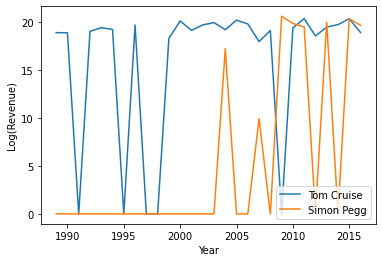

In [44]:
feat_name_tmpl = generate_feat_data_name_tmpl("role_logrev")
year_pair_to_role_logrev = {}

years = []
revs = []
revs2 = []
actor = "Tom Cruise"
actor2 = "Simon Pegg"
for year_pair in generate_year_pairs(1990, 2017, 1):
    role_logrev = loadFeature(feat_name_tmpl.format(d="all", r="actor",
                                                    sy=year_pair[0], ey=year_pair[1]))
    revs.append(role_logrev.get(actor, 0))
    revs2.append(role_logrev.get(actor2, 0))
    print(year_pair[0], revs2)
    years.append(year_pair[0])
import matplotlib.pyplot as plt
plt.plot(years, revs, label=actor)
plt.plot(years, revs2, label=actor2)
plt.xlabel("Year")
plt.ylabel("Log(Revenue)")
#plt.title("Average log(revenue) in the past 5 years")
plt.legend(loc="lower right")
plt.show()

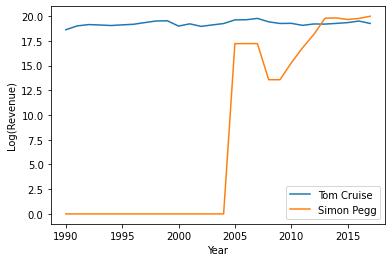

In [52]:
feat_name_tmpl = generate_feat_data_name_tmpl("role_logrev")
year_pair_to_role_logrev = {}

years = []
revs = []
revs2 = []
actor = "Tom Cruise"
actor2 = "Simon Pegg"
#for year_pair in generate_year_pairs(1990, 2017, 1):
for year_pair in generate_year_pairs(1990, 2017, 5):
#for year_pair in generate_year_pairs(1990, 2017, 2):
    role_logrev = loadFeature(feat_name_tmpl.format(d="all", r="actor",
                                                    sy=year_pair[0], ey=year_pair[1]))
    revs.append(role_logrev.get(actor, 0))
    revs2.append(role_logrev.get(actor2, 0))
    years.append(year_pair[1])
import matplotlib.pyplot as plt
plt.plot(years, revs, label=actor)
plt.plot(years, revs2, label=actor2)
plt.xlabel("Year")
plt.ylabel("Log(Revenue)")
#plt.title("Average log(revenue) in the past 5 years")
plt.legend(loc="lower right")
plt.show()

In [20]:
idx_col_name = "id"
actor_col_name = "top5_actors"
director_col_name = "top1_director"
crew_col_name = "crew"
logrev_col_name = "log_revenue_num"
rev_col_name = "revenue_new"
year_col_name = "release_year"
prod_cmp_col_name = "production_company_class"

role_names = ["actor", "director"]
role_to_k = {"actor": 100, "director": 50}

role_to_max_num_roles = {"actor": 5, "director": 1}
role_to_col_name = {"actor": actor_col_name, "director": director_col_name}
min_year = 1990
durations = [2, 5, 10]

converters = {crew_col_name: eval, actor_col_name: eval}

data_name_pair_dict = {
    #("subtrain", "val"): ("train_sub_1980_2012_prod_comp_class.csv",
    #                      "val_2013_2014_prod_comp_class.csv"),
    #("train", "test"): ("train_1980_2014_prod_comp_class.csv", 
    #                    "test_2015_2017_prod_comp_class.csv")
    ("subtrain", "val"): ("train_sub_1980_2012_prod_comp_class_actor_director_istopk_logrev_genres.csv",
                          "val_2013_2014_prod_comp_class_actor_director_istopk_logrev_genres.csv"),
    ("train", "test"): ("train_1980_2014_prod_comp_class_actor_director_istopk_logrev_genres.csv", 
                        "test_2015_2017_prod_comp_class_actor_director_istopk_logrev_genres.csv")
}

output_data_name_pair_dict = {
    ("subtrain", "val"): ("train_sub_1990_2012_final.csv",
                          "val_2013_2014_final.csv"),
    ("train", "test"): ("train_1990_2014_final.csv", 
                        "test_2015_2017_final.csv")
}

data_dict = {}
for data_name_pair in data_name_pair_dict:
    train_data_name, test_data_name = data_name_pair
    train_data_file_name = data_name_pair_dict[data_name_pair][0]
    test_data_file_name = data_name_pair_dict[data_name_pair][1]
    train_df = read_dataset(train_data_file_name, converters,
                            idx_col_name, crew_col_name, director_col_name)
    test_df = read_dataset(test_data_file_name, converters,
                           idx_col_name, crew_col_name, director_col_name)
    train_df = generate_production_company_class_onehot(train_df, prod_cmp_col_name)
    test_df = generate_production_company_class_onehot(test_df, prod_cmp_col_name)
    train_start_year = max(min_year, train_df[year_col_name].min())
    train_end_year = train_df[year_col_name].max()

    data_dict[train_data_name] = {"df": train_df, "is_train": True,
                                  "train_data_name": train_data_name,
                                  "train_start_year": train_start_year,
                                  "train_end_year": train_end_year}
    data_dict[test_data_name] = {"df": test_df, "is_train": False,
                                 "train_data_name": train_data_name,
                                 "train_start_year": train_start_year,
                                 "train_end_year": train_end_year}                                  

In [16]:
# Generate is_topk_roles & role_logrev (actor/director) features from training data
for data_name, data in data_dict.items():
    df, is_train = data["df"], data["is_train"]
    if not is_train:
        continue
    for role_name in role_names:
        role_col_name = role_to_col_name[role_name]
        role_k = role_to_k[role_name]
        max_num_roles = role_to_max_num_roles[role_name]
        for duration in durations:
            generate_is_topk_role_feature(role_name, role_k, duration, data_name,
                                          df, role_col_name, year_col_name, min_year)
            generate_role_logpop_feature(role_name, duration, data_name,
                                         df, role_col_name, year_col_name, min_year)
            generate_role_logrev_feature(role_name, duration, data_name, df, role_col_name,
                                         rev_col_name, year_col_name, max_num_roles, min_year)

In [ ]:
feat_name_tmpl = generate_feat_data_name_tmpl("is_topk_roles")

year_pair = (1995, 2000)
topk_actor_freqs = loadFeature(feat_name_tmpl.format(d="train", k=100, r="actor",
                                                     sy=year_pair[0], ey=year_pair[1]))

topk_actor_set = set([actor for actor, freq in topk_actor_freqs])
all_actors = list(set([actor for actors in data_dict["train"]["df"]["top5_actors"] for actor in actors]))
non_topk_actors = []
for actor in all_actors:
    if actor not in topk_actor_set:
        non_topk_actors.append(actor)
non_topk_actors



In [84]:
# Add feature columns of is_topk_roles (actor/director) features
for data_name, data in data_dict.items():
    is_train = data["is_train"]
    train_data_name = data["train_data_name"]
    train_start_year = data["train_start_year"]
    train_end_year = data["train_end_year"]
    for role_name in role_names:
        for duration in durations:
            role_col_name = role_to_col_name[role_name]
            role_k = role_to_k[role_name]
            max_num_roles = role_to_max_num_roles[role_name]
            year_pair_to_topk_roles = generate_year_pair_to_topk_roles(
                role_name, role_k, duration, train_data_name, train_start_year, train_end_year
            )
            data_dict[data_name]["df"] = addIsTopKRolesFeatCol(
                role_name, role_k, duration, year_pair_to_topk_roles,
                data_dict[data_name]["df"], role_col_name, year_col_name,
                max_num_roles, is_train
            )

In [85]:
# Add feature columns of role_log_pop (actor/director) features
for data_name, data in data_dict.items():
    is_train = data["is_train"]
    train_data_name = data["train_data_name"]
    train_start_year = data["train_start_year"]
    train_end_year = data["train_end_year"]
    for role_name in role_names:
        for duration in durations:
            role_col_name = role_to_col_name[role_name]
            role_k = role_to_k[role_name]
            max_num_roles = role_to_max_num_roles[role_name]
            year_pair_to_role_logpop = generate_year_pair_to_role_logpop(
                role_name, duration, train_data_name, train_start_year, train_end_year
            )
            data_dict[data_name]["df"] = addRoleLogPopFeatCol(
                role_name, duration, year_pair_to_role_logpop,
                data_dict[data_name]["df"], role_col_name, year_col_name,
                max_num_roles, is_train
            )

In [86]:
# Add feature columns of role_logrev (actor/director) features
for data_name, data in data_dict.items():
    is_train = data["is_train"]
    train_data_name = data["train_data_name"]
    train_start_year, train_end_year = data["train_start_year"], data["train_end_year"]
    for role_name in role_names:
        for duration in durations:
            role_col_name = role_to_col_name[role_name]
            role_k = role_to_k[role_name]
            max_num_roles = role_to_max_num_roles[role_name]
            year_pair_to_role_logrev = generate_year_pair_to_role_logrev(
                role_name, duration, train_data_name, train_start_year, train_end_year
            )
            data_dict[data_name]["df"] = addRoleLogRevFeatCol(
                role_name, duration, year_pair_to_role_logrev,
                data_dict[data_name]["df"], role_col_name, year_col_name,
                #max_num_roles, is_train, filling_method="linear_extrapolation"
                max_num_roles, is_train, filling_method="max_year"
                #max_num_roles, is_train, filling_method="cubic_extrapolation"
                #max_num_roles, is_train, filling_method="median"
            )

In [87]:
for data_name_pair in output_data_name_pair_dict:
    train_data_name, test_data_name = data_name_pair
    train_output_data_file_name = output_data_name_pair_dict[data_name_pair][0]
    test_output_data_file_name = output_data_name_pair_dict[data_name_pair][1]
    train_indices = data_dict[train_data_name]["df"][year_col_name] >= min_year
    test_indices = data_dict[test_data_name]["df"][year_col_name] >= min_year
    data_dict[train_data_name]["df"][train_indices].to_csv(path + train_output_data_file_name)
    data_dict[test_data_name]["df"][test_indices].to_csv(path + test_output_data_file_name)